# Construct Custom Models from simulators and JAX callables

In [1]:
import os
import pickle

import arviz as az
import jax.numpy as jnp
import lanfactory as lf
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm

import hssm
from hssm.config import ModelConfig

wandb not available
wandb not available


### Simulate Data

As a pre-amble, we will simulate a simple dataset from the DDM model to use through the example.

In [2]:
# simulate some data from the model
obs_ddm = hssm.simulate_data(
    theta=dict(v=0.25, a=1.25, t=0.2, z=0.5),
    model="ddm",
    size=1000
)

## Construct PyMC distribution from simulator and JAX callable


#### Create JAX Log-likelihood Callable

What we need is a callable that takes in a matrix that stacks model parameters and data trialwise, hence with input dimensions: $trials \times (dim-parameters + dim-data)$. The function should return a vector of length $trials$ that contains the log-likelihood for each trial.

If we have a JAX function with this signature, we will be able to proceed to create a valid PyMC distribution form helper functions provided by `hssm`.

In this particular example, we will reinstantiate a pretrained [LAN](https://elifesciences.org/articles/65074) via utilities from the [`lanfactory`](https://github.com/AlexanderFengler/LANfactory) package. This is not necessary, but illustrates how to make use of the braoder ecosystem around HSSM.

> **Note:** `lanfactory` is an optional dependency of `hssm` and can be installed using the command `pip install hssm[notebook]`. Alternatively, you can install it directly with `pip install lanfactory`.

In [3]:
# Loaded Net
jax_infer = lf.trainers.MLPJaxFactory(
    network_config=pickle.load(
        open(
            os.path.join(
                "data", "jax_models", "ddm", "ddm_jax_lan_network_config.pickle"
            ),
            "rb",
        )
    ),
    train=False,
)

jax_mlp_forward, _ = jax_infer.make_forward_partial(
    seed=42,
    input_dim=4 + 2,  # n-parameters (v,a,z,t) + n-data (rts and choices)
    state=os.path.join("data", "jax_models", "ddm", "ddm_jax_lan_train_state.jax"),
    add_jitted=True,
)

##### Checking the signature of the JAX callable

We can test the signature of the JAX callable by passing in a batch of inputs and checking the output shape.

In [4]:
# Testing the signature of the JAX function 2
n_dim_model_parameters = 4
n_dim_data = 2
n_trials = 1
in_ = jnp.zeros((n_trials,
                 n_dim_model_parameters + n_dim_data))
out = jax_mlp_forward(in_)
print(out.shape)

(1, 1)


In [5]:
from hssm.distribution_utils.jax import make_jax_single_trial_logp_from_network_forward
import jax.numpy as jnp
jax_logp = make_jax_single_trial_logp_from_network_forward(jax_forward_fn = jax_mlp_forward,
                                                           params_only = False)

In [6]:
# Test call
jax_logp(jnp.zeros((2)),
         jnp.array([1.0]),
         jnp.array([1.5]),
         jnp.array([0.5]),
         jnp.array([0.3]))

Array(-20.01882519, dtype=float64)

#### Decorate and wrap a simulator

The simulator-signature expected by `hssm` is the following:

A simulator is a callable that takes in a matrix that stacks model parameters and data trialwise, hence with input dimensions: $trials \times (|paramters))$. The function should return a matrix of shape $trials \times |data|$.

We will use the `decorate_atomic_simulator()` utility to annotate the simulator with necessary metadata we use the `hssm_sim_wrapper()` function from the `ssm-simulators` package to make our simulator ready for usage inside a `PyTensor` `RandomVariable` later. 

If you check the signature of the resulting `rv_ready_simulator`, you should find no problems shoe-horning your own custon simulator into the corresponding behavior.

`decorate_atomic_simulator()` is just a `Python` `decorator` that you can use around any function.

You can start from any simulator you like, we use the one from the [`ssm-simulators`](https://alexanderfengler.github.io/ssm-simulators/) package for convenience.

In [7]:
from ssms.hssm_support import hssm_sim_wrapper, decorate_atomic_simulator
from functools import partial
from ssms.basic_simulators.simulator import simulator

rv_ready_simulator = partial(hssm_sim_wrapper, 
                             simulator_fun = simulator,
                             model = "ddm", 
                             n_replicas = 1) # AF-TODO: n_replicas should default to 1 instead of being required

# We decorate the simulator to attach some metadata
# that HSSM can use
decorated_simulator = decorate_atomic_simulator(
    model_name="ddm", choices=[-1, 1], obs_dim=2
)(rv_ready_simulator)

##### Checking the signature of the decorated simulator

We can check the signature of the decorated simulator by passing in a batch of parameters and checking the output shape.


In [8]:
decorated_simulator(
    theta=np.tile(np.array([1.0, 1.5, 0.5, 0.2]), (10, 1)), random_state=42
)

array([[ 2.02210951,  1.        ],
       [ 2.58906269,  1.        ],
       [ 1.1866796 ,  1.        ],
       [ 1.06390691,  1.        ],
       [ 1.32591701,  1.        ],
       [ 1.04748344,  1.        ],
       [ 1.37392318,  1.        ],
       [ 0.78049529, -1.        ],
       [ 1.6851691 ,  1.        ],
       [ 1.10256469,  1.        ]])

#### Create valid PyMC distribution

We have all ingredients to create a valid PyMC distribution, form a few helper functions provided by `hssm` at this point.

A valid Distribution will need two ingredients:

1. A `RandomVariable` (RV) that encodes the simulator and parameter names.
2. A likelihood function, which is a valid PyTensor `Op` that encodes the log-likelihood of the model.

We will use the `make_hssm_rv()` helper function to create the `RandomVariable` and the `make_likelihood_callable()` helper function to create the likelihood `Op`.

Finally, the `make_distribution()` helper function will package everything into a valid PyMC distribution.


**NOTE**:

There are a few helpful settings which we can use to customize our distribution. We will not cover all details here, however it is worth highlighting the `params_is_reg` argument in `make_likelihood_callable()`. This argument is used to tell PyMC whether the parameter is a regression parameter or not. Specifically, if a parameter is treated as a regression, the likelihood function is built to assume that the parameter is passed trial-wise, i.e. as a vector of length `n_trials`.

Note here, we set all parameters to be non-regression parameters, as we expect the parameters to be passed as single values in the simple `PyMC` model below.

In [9]:
from hssm.distribution_utils.dist import (
    make_distribution,
    make_hssm_rv,
    make_likelihood_callable,
)

# Step 1: Define a pytensor RandomVariable
CustomRV = make_hssm_rv(
    simulator_fun=decorated_simulator,
    list_params=["v", "a", "z", "t"]
)

# Step 2: Define a likelihood function
logp_jax_op = make_likelihood_callable(
    loglik=jax_logp,
    loglik_kind="approx_differentiable",
    backend="jax",
    params_is_reg=[True, False, False, False],
    params_only=False,
)

# Step 3: Define a distribution
CustomDistribution = make_distribution(
    rv=CustomRV,
    loglik=logp_jax_op,
    list_params=["v", "a", "z", "t"],
    bounds=dict(v=(-3, 3), a=(0.5, 3.0), z=(0.1, 0.9), t=(0, 2.0)),
)

passing here: 
params_only:  False
params_is_reg:  [True, False, False, False]


We can now test the distribution by passing it to a simple PyMC model.

In [10]:
from pytensor import tensor as pt
# Test via basic pymc model
with pm.Model() as model_pymc:
    v = pm.Normal("v", mu=0, sigma=1)
    a = pm.Uniform("a", lower=0.5, upper=3.0)
    z = pm.Beta("z", alpha=10, beta=10)
    t = pm.Weibull("t", alpha=0.5, beta=1.0)

    # We define `v` as a vector of length `n_trials`
    # To conform to the expected signature of the likelihood function
    v_det = pm.Deterministic("v_det", v * pt.ones(obs_ddm.shape[0]))
    CustomDistribution("custom", observed=obs_ddm.values, v=v_det, a=a, z=z, t=t)


max_shape:  (1000,)
size:  (np.int64(1000),)


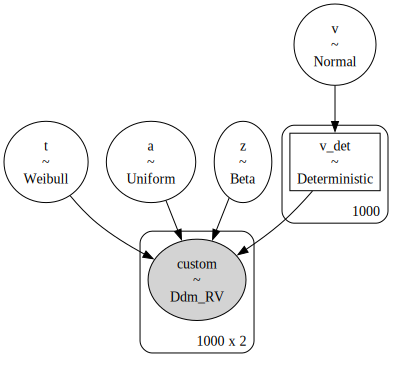

In [11]:
pm.model_to_graphviz(model_pymc)

In [12]:
with model_pymc:
    idata = pm.sample(draws=200,
                      tune=500,
                      chains=2,
                      nuts_sampler="numpyro")

/Users/afengler/Library/CloudStorage/OneDrive-Personal/proj_hssm/HSSM/.venv/lib/python3.11/site-packages/pymc/sampling/jax.py:475: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
sample: 100%|██████████| 700/700 [00:11<00:00, 62.16it/s, 7 steps of size 5.71e-01. acc. prob=0.83]  
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/

In [13]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v,0.309,0.185,0.097,0.519,0.128,0.001,3.0,236.0,1.83
a,1.278,0.025,1.232,1.320,0.009,0.001,8.0,176.0,1.22
z,0.477,0.039,0.428,0.530,0.027,0.000,3.0,261.0,1.83
t,0.201,0.018,0.165,0.230,0.005,0.001,14.0,219.0,1.13
v_det[0],0.309,0.185,0.097,0.519,0.128,0.001,3.0,236.0,1.83
...,...,...,...,...,...,...,...,...,...
v_det[995],0.309,0.185,0.097,0.519,0.128,0.001,3.0,236.0,1.83
v_det[996],0.309,0.185,0.097,0.519,0.128,0.001,3.0,236.0,1.83
v_det[997],0.309,0.185,0.097,0.519,0.128,0.001,3.0,236.0,1.83
v_det[998],0.309,0.185,0.097,0.519,0.128,0.001,3.0,236.0,1.83


array([[<Axes: title={'center': 'v'}>, <Axes: title={'center': 'v'}>],
       [<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'z'}>, <Axes: title={'center': 'z'}>],
       [<Axes: title={'center': 't'}>, <Axes: title={'center': 't'}>],
       [<Axes: title={'center': 'v_det'}>,
        <Axes: title={'center': 'v_det'}>]], dtype=object)

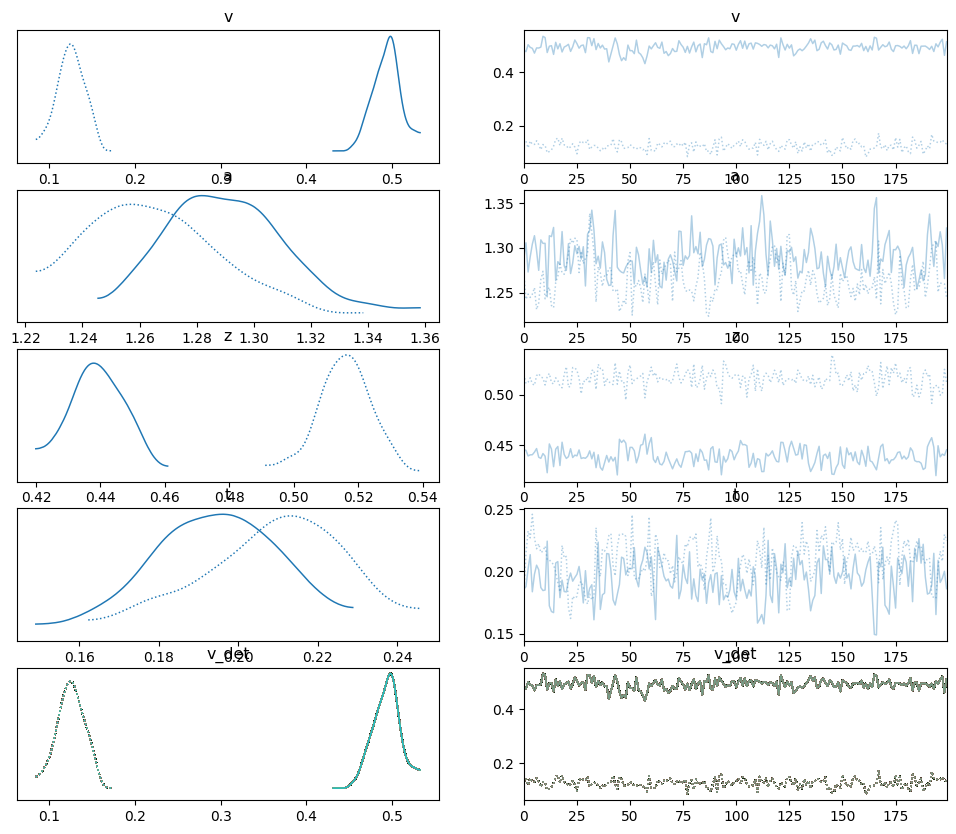

In [14]:
az.plot_trace(idata)

## Custom HSSM model from simulator and JAX callable


Next, we will create a custom HSSM model from the simulator and JAX callable.
After the work we have done above, this is now very straightforward.

The only `hssm` specific extra step is to define a `ModelConfig` object, 
which bundles all information about the model.

Then we pass our `ModelConfig` object to the `HSSM` class, along with the data and the log-likelihood function,
and `hssm` will take care of the rest. 

Importantly, `hssm` will automatically understand how to construct the correct likelihood function
for the specified model configuration (parameter-wise regression settings, etc.). A step we have 
to accomplish manually in the code above.

In [15]:
# Define model config
my_custom_model_config = ModelConfig(
    response=["rt", "response"],
    list_params=["v", "a", "z", "t"],
    bounds={
        "v": (-2.5, 2.5),
        "a": (1.0, 3.0),
        "z": (0.0, 0.9),
        "t": (0.001, 2),
    },
    rv=decorated_simulator,
    backend="jax",
    choices=[-1, 1],
)

You have specified the `lapse` argument to include a lapse distribution, but `p_outlier` is set to either 0 or None. Your lapse distribution will be ignored.
passing here: 
params_only:  False
params_is_reg:  [True, False, False, False]
Model initialized successfully.
max_shape:  (1000,)
size:  (np.int64(1000),)


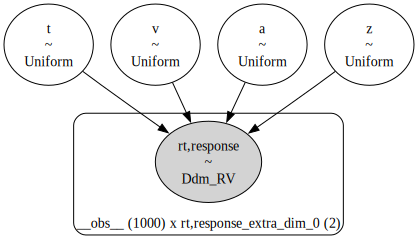

In [16]:
# Define the HSSM model
model = hssm.HSSM(
    data=obs_ddm,
    model="my_new_model",  # some name for the model
    model_config=my_custom_model_config,
    loglik_kind="approx_differentiable",  # use the blackbox loglik
    loglik=jax_logp,
    p_outlier=0,
)

model.graph()

In [18]:
# Test sampling
model.sample(draws=500,
             tune=200,
             nuts_sampler="numpyro",
             discard_tuned_samples=False)

Using default initvals. 



/Users/afengler/Library/CloudStorage/OneDrive-Personal/proj_hssm/HSSM/.venv/lib/python3.11/site-packages/pymc/sampling/jax.py:475: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
100%|██████████| 2000/2000 [00:01<00:00, 1119.52it/s]


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

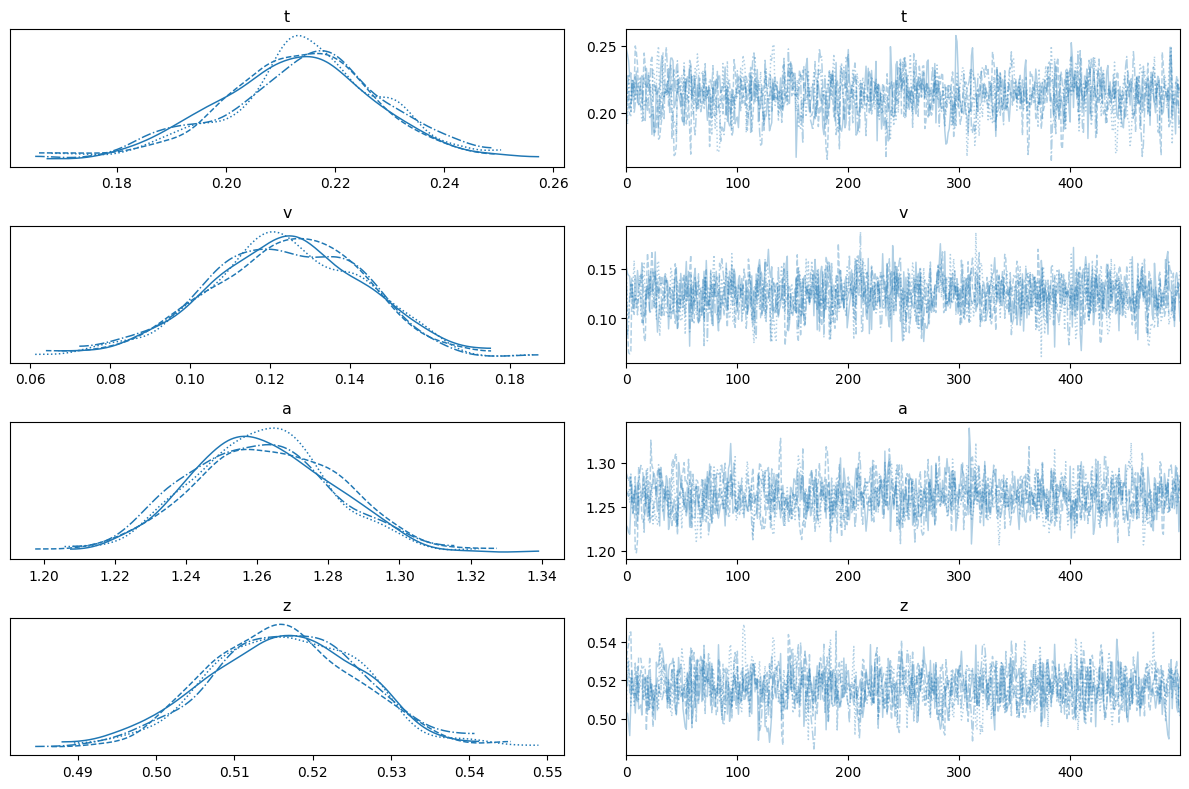

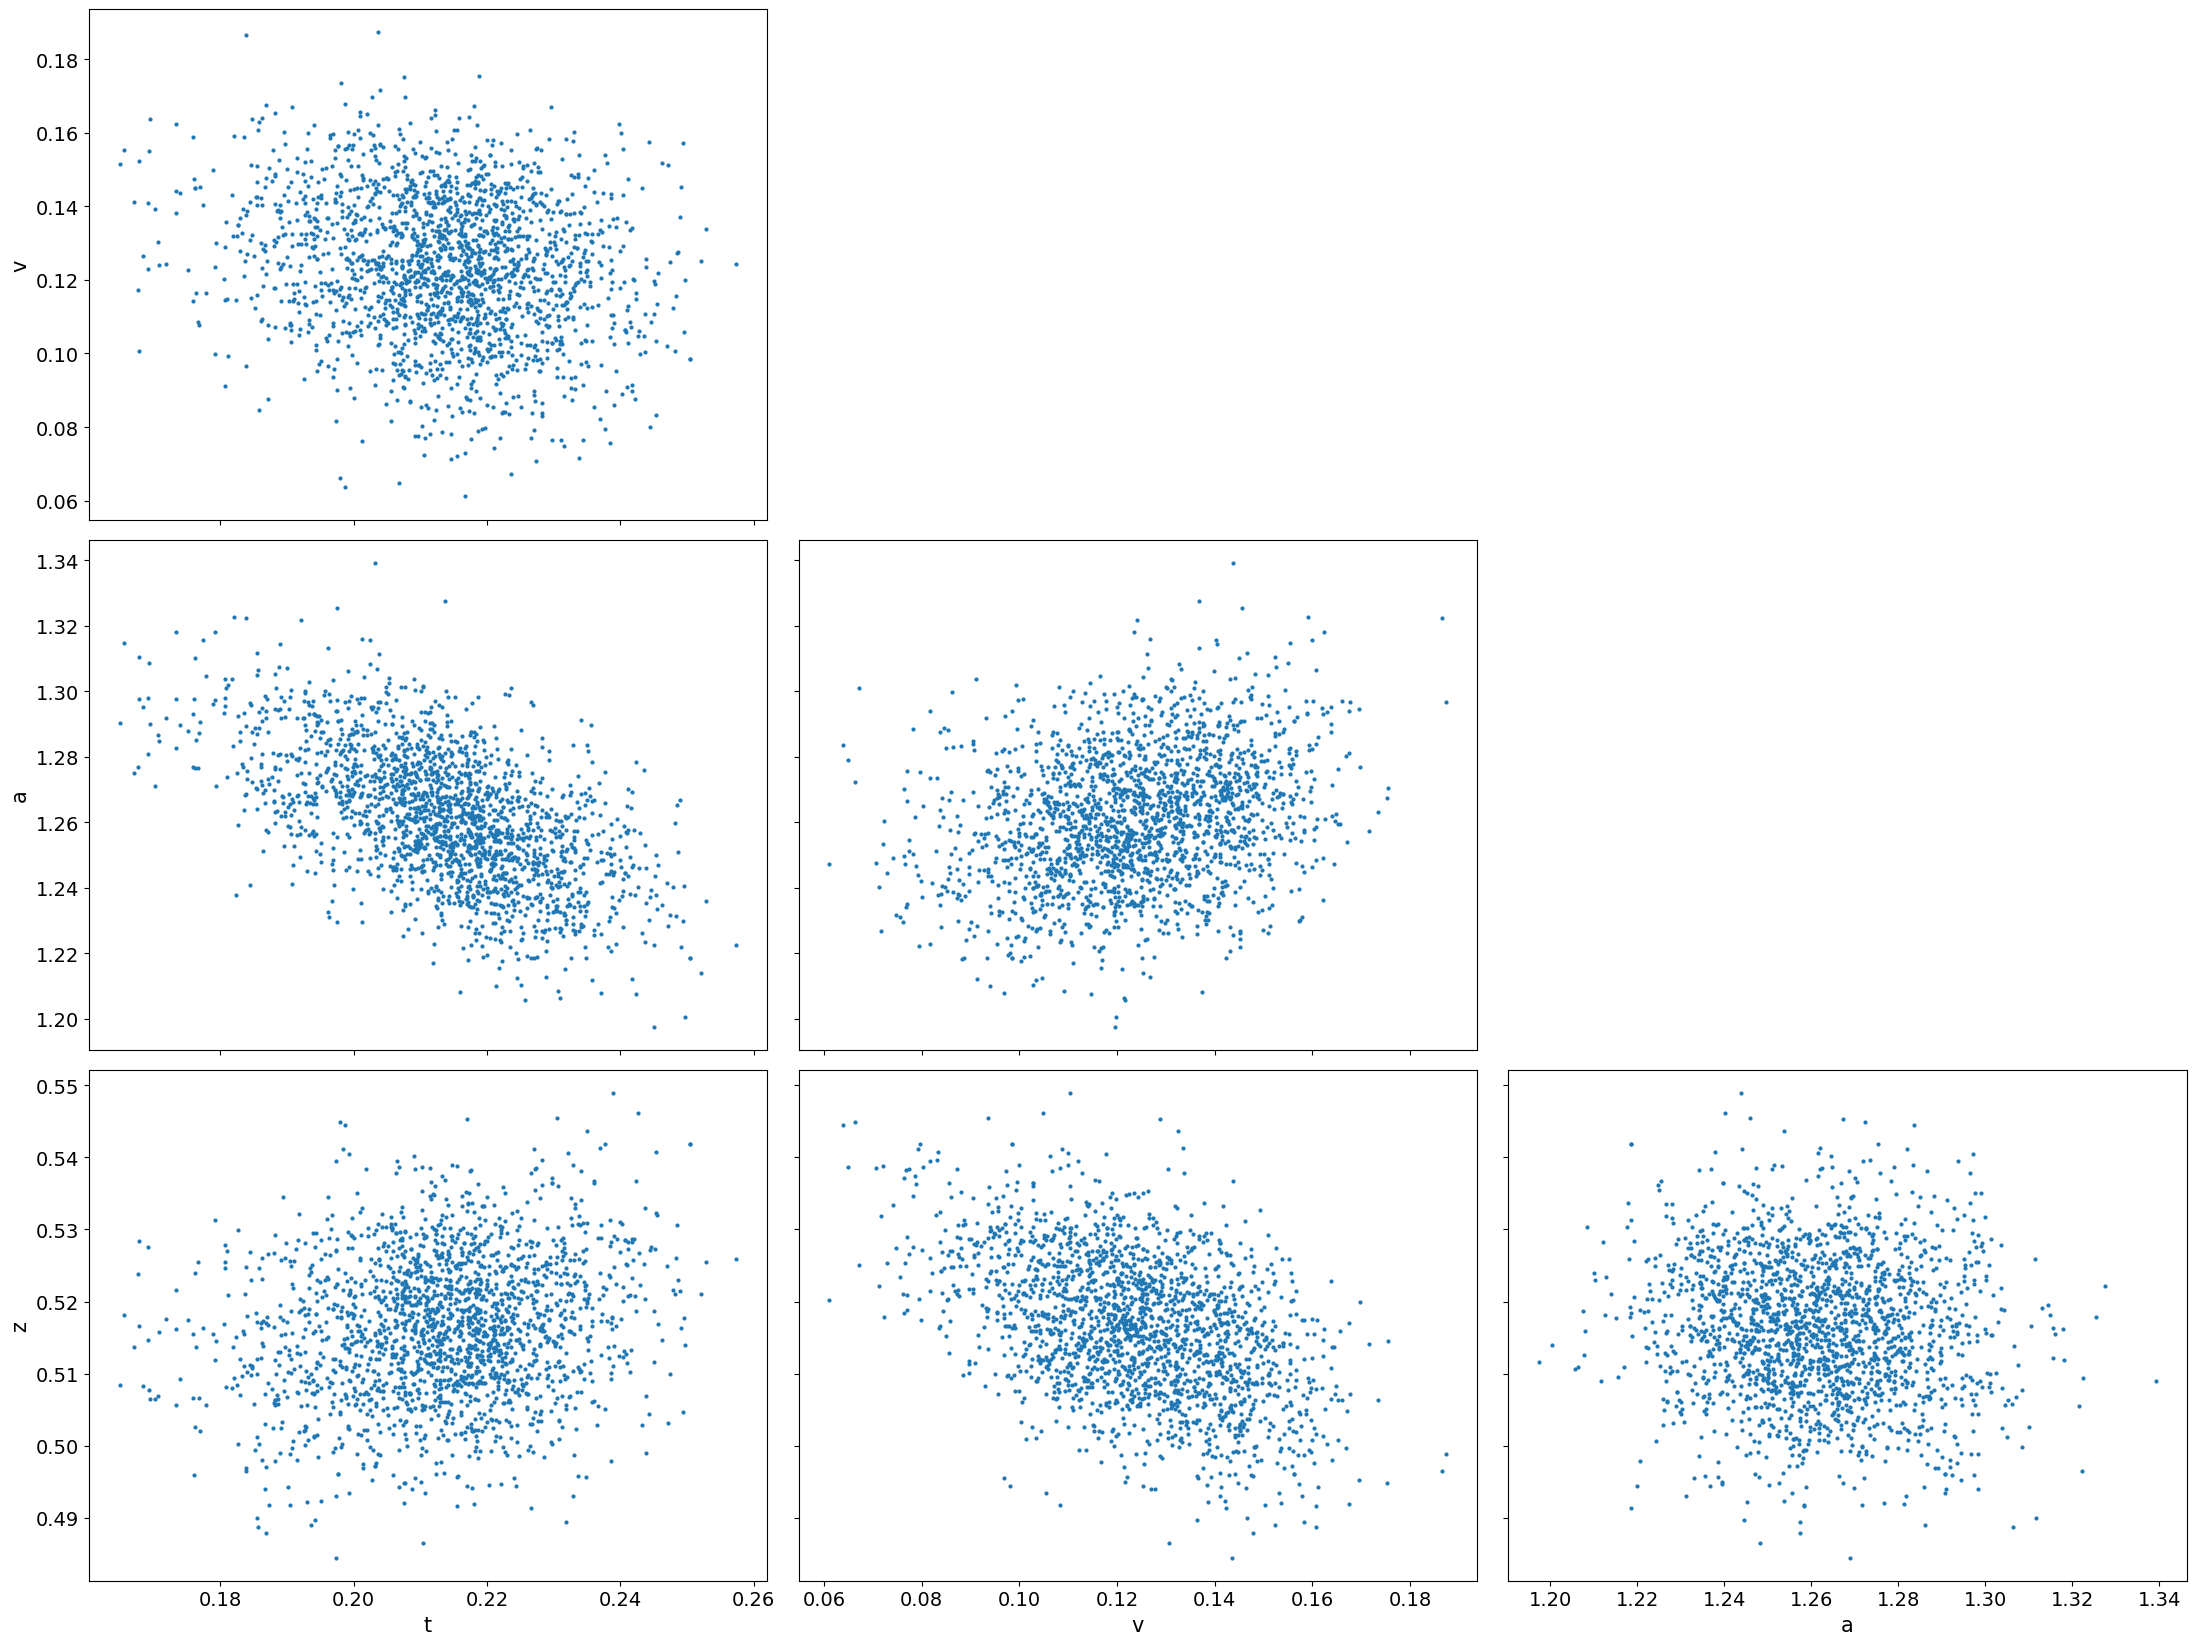

In [19]:
az.plot_trace(model.traces)
plt.tight_layout()

az.plot_pair(model.traces)
plt.tight_layout()

We hope you find it easy to use the above example to leverage `hssm` to fit your own custom models.